In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

In [75]:
# Load the data
price_data = pd.read_csv('D:\GitHub\Equity Project\B Separating Files for Backtest\Price_data_After_June_2023.csv')
#price_data = pd.read_csv('D:\GitHub\Equity Project\B Separating Files for Backtest\Price_data_Before_June_2023.csv')
fed_funds = pd.read_csv('D:\GitHub\Equity Project\AB Fed Funds Rate\FEDFUNDS.csv')

# Convert date columns to datetime
price_data['Date'] = pd.to_datetime(price_data['Date'])
fed_funds['Date'] = pd.to_datetime(fed_funds['Date'])


price_data = price_data[(price_data['Days from Announce'] > 0)]
print(len(price_data))


23597


In [76]:
index_event_data = pd.read_csv('D:\GitHub\Equity Project\B Separating Files for Backtest\Index_Event_Data_After_June_2023.csv')

# Extract and sort the list of unique indices and actions
indices = sorted(index_event_data['Index Change'].unique())
cleaned_actions = sorted(index_event_data['Action'].unique())

# Create a two-way table (pivot table)
two_way_table = pd.pivot_table(index_event_data, values='Ticker', index='Index Change', columns='Action', aggfunc='count', fill_value=0)

two_way_table.loc['Total',:]= two_way_table.sum(axis=0)
two_way_table.loc[:,'Total'] = two_way_table.sum(axis=1)

# Display the two-way table
print("\nTwo-way table showing the count of entries for each action and index:")
two_way_table


Two-way table showing the count of entries for each action and index:


Action,Add,Delete,Downweight,Drop from SP600,MSCI Std to SC,Reclassification,SP400 to SP500,SP400 to SP600,SP500 to SP400,SP500 to SP600,SP600 to SP400,Upweight,Total
Index Change,,,,,,,,,,,,,
MSCI SC,7.0,81.0,6.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0,232.0
MSCI Std,6.0,8.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,46.0
Nasdaq 100,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
Russell 1000,14.0,18.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0,89.0
Russell 2000,8.0,69.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,138.0
S&P Completion,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,11.0
SP400,34.0,11.0,1.0,0.0,0.0,0.0,2.0,17.0,1.0,0.0,5.0,23.0,94.0
SP500,9.0,3.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,6.0,0.0,29.0,54.0
SP600,30.0,40.0,1.0,18.0,0.0,0.0,0.0,27.0,0.0,7.0,5.0,23.0,151.0


# 1 Simple Strategy without Hedges

We first look at the return of the following strategy, without any hedge:

1. For "Add" events,

   a. For SP500 and SP600, to long for 5 days;

   b. For other indices, to short on the day after announcement, close this position after 5 days.

2. For "Delete" events,

   a. To short stocks impacted by SP 400, 500, 600 deletion events, and cover the position in 5 day;

   b. To long stocks impacted by MSCI SC, NASDAQ 100, and Russell 2000 in 5 days.

3. For "Upweight" events,

   a. To Long SP 500 after "Upweight" announcement for 5 days;

   b. To Short other indices' "Upweight" announcement for 5 days, cover, then long for 5 days.

4. For "Downweight" events, we take no actions (due to lack of data)

5. For "Reclassification" events, to short, and close the positions after 5 days.

In [78]:
# Function to get fed rate
def get_fed_rate(date):
    # Get the latest fed rate before or on the given date and convert to decimal
    rate = fed_funds.loc[fed_funds['Date'] <= date].iloc[-1]['FEDFUNDS'] / 100
    return rate

# Function to calculate transaction costs
def calculate_transaction_costs(shares):
    return shares * 0.01

# Adjust calculation of overnight costs based on daily rates
def calculate_overnight_costs(position_value, fed_rate, days, long=True):
    daily_rate = (fed_rate + 0.01) / 365 if long else (fed_rate + 0.015) / 365
    return position_value * daily_rate * days

# Calculate the 20-day average volume for each stock
price_data['20D_AVG_VOLUME'] = price_data.groupby('Ticker')['Volume'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())


In [79]:
grouped_data = price_data.groupby(['Ticker', 'Index', 'Action', 'Shares Traded'])
len(grouped_data)


587

In [80]:
# Apply strategy based on event rules with liquidity constraint
def apply_strategy_with_liquidity(price_data):
    portfolio_value = 5000000
    positions = []

    grouped_data = price_data.groupby(['Ticker', 'Index', 'Action', 'Shares Traded'])

    for name, group in grouped_data:
        ticker, index, action, shares_traded = name

        if action == 'Add':
            if index in ['SP500', 'SP600']:
                # Long on day 1, sell on day 5
                d = group['Days from Announce'].min()
                long_day = group[group['Days from Announce'] == d]
                sell_day = group[group['Days from Announce'] == d+5]
                if not long_day.empty and not sell_day.empty:
                    buy_price = long_day.iloc[0]['Open']
                    sell_price = sell_day.iloc[0]['Close']
                    avg_volume = long_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares = avg_volume * 0.01
                    end = sell_day.iloc[0]['Date']

                    shares = min(portfolio_value // buy_price, max_shares)
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * buy_price, get_fed_rate(long_day.iloc[0]['Date']), 4, long=True)

                    pnl = (sell_price - buy_price) * shares - transaction_costs - overnight_costs
                    portfolio_value += pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

            else:
                # Long on day 1, sell on day 5
                d = group['Days from Announce'].min()
                short_day = group[group['Days from Announce'] == d]
                cover_day = group[group['Days from Announce'] == d+5]

                if not short_day.empty and not cover_day.empty:
                    short_price = short_day.iloc[0]['Open']
                    cover_price = cover_day.iloc[0]['Close']
                    avg_volume = short_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares = avg_volume * 0.01
                    end = cover_day.iloc[0]['Date']

                    shares = min(portfolio_value // short_price, max_shares)
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * short_price, get_fed_rate(short_day.iloc[0]['Date']), 4, long=False)

                    pnl = (short_price - cover_price) * shares - transaction_costs - overnight_costs
                    portfolio_value += pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

        elif action == 'Delete':
            if index in ['SP400', 'SP500', 'SP600']:
                # short on day 1, cover on day 5
                d = group['Days from Announce'].min()
                short_day = group[group['Days from Announce'] == d]
                cover_day = group[group['Days from Announce'] == d+5]

                if not short_day.empty and not cover_day.empty:
                    short_price = short_day.iloc[0]['Open']
                    cover_price = cover_day.iloc[0]['Close']
                    avg_volume = short_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares = avg_volume * 0.01
                    end = cover_day.iloc[0]['Date']
                    
                    shares = min(portfolio_value // short_price, max_shares)
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * short_price, get_fed_rate(short_day.iloc[0]['Date']), 4, long=False)

                    pnl = (short_price - cover_price) * shares - transaction_costs - overnight_costs
                    portfolio_value += pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

            elif index in ['MSCI SC', 'NASDAQ 100', 'Russell 2000']:
                # Long on day 1, sell on day 5
                d = group['Days from Announce'].min()
                long_day = group[group['Days from Announce'] == d]
                sell_day = group[group['Days from Announce'] == d+5]

                if not long_day.empty and not sell_day.empty:
                    buy_price = long_day.iloc[0]['Open']
                    sell_price = sell_day.iloc[0]['Close']
                    avg_volume = long_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares = avg_volume * 0.01
                    end = sell_day.iloc[0]['Date']

                    shares = min(portfolio_value // buy_price, max_shares)
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * buy_price, get_fed_rate(long_day.iloc[0]['Date']), 4, long=True)

                    pnl = (sell_price - buy_price) * shares - transaction_costs - overnight_costs
                    portfolio_value += pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

        elif action == 'Upweight':
            if index == 'SP500':
                # Long on day 1, sell on day 15
                d = group['Days from Announce'].min()
                long_day = group[group['Days from Announce'] == d]
                sell_day = group[group['Days from Announce'] == d+5]

                if not long_day.empty and not sell_day.empty:
                    buy_price = long_day.iloc[0]['Open']
                    sell_price = sell_day.iloc[0]['Close']
                    avg_volume = long_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares = avg_volume * 0.01
                    end = sell_day.iloc[0]['Date']

                    shares = min(portfolio_value // buy_price, max_shares)
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * buy_price, get_fed_rate(long_day.iloc[0]['Date']), 4, long=True)

                    pnl = (sell_price - buy_price) * shares - transaction_costs - overnight_costs
                    portfolio_value += pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

            else:
                # Short on day 1, cover on day 5, long on day 6, sell on day 10
                d = group['Days from Announce'].min()
                short_day = group[group['Days from Announce'] == d]
                cover_day = group[group['Days from Announce'] == d+5]
                long_day = group[group['Days from Announce'] == d+6]
                sell_day = group[group['Days from Announce'] == d+10]

                if not short_day.empty and not cover_day.empty and not long_day.empty and not sell_day.empty:
                    short_price = short_day.iloc[0]['Open']
                    cover_price = cover_day.iloc[0]['Close']
                    buy_price = long_day.iloc[0]['Open']
                    sell_price = sell_day.iloc[0]['Close']
                    avg_volume_short = short_day.iloc[0]['20D_AVG_VOLUME']
                    avg_volume_long = long_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares_short = avg_volume_short * 0.01
                    max_shares_long = avg_volume_long * 0.01
                    end = sell_day.iloc[0]['Date']

                    shares_short = min(portfolio_value // short_price, max_shares_short)
                    shares_long = min(portfolio_value // buy_price, max_shares_long)
                    transaction_costs = calculate_transaction_costs(shares_short) + calculate_transaction_costs(shares_long)
                    overnight_costs_short = calculate_overnight_costs(shares_short * short_price, get_fed_rate(short_day.iloc[0]['Date']), 4, long=False)
                    overnight_costs_long = calculate_overnight_costs(shares_long * buy_price, get_fed_rate(long_day.iloc[0]['Date']), 4, long=True)

                    pnl_short = (short_price - cover_price) * shares_short - transaction_costs - overnight_costs_short
                    pnl_long = (sell_price - buy_price) * shares_long - overnight_costs_long

                    portfolio_value += pnl_short + pnl_long
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl_short + pnl_long})

        elif action in ['MSCI SC to Std', 'MSCI Std to SC', 'SP400 to SP600', 'SP400 to SP500', 'SP500 to SP400', 'SP500 to SP600', 'SP600 to SP400', 'SP600 to SP500']:
            # Short on day 1, cover on day 5
            d = group['Days from Announce'].min()
            short_day = group[group['Days from Announce'] == d]
            cover_day = group[group['Days from Announce'] == d+5]

            if not short_day.empty and not cover_day.empty:
                short_price = short_day.iloc[0]['Open']
                cover_price = cover_day.iloc[0]['Close']
                avg_volume = short_day.iloc[0]['20D_AVG_VOLUME']
                max_shares = avg_volume * 0.01
                end = cover_day.iloc[0]['Date']

                shares = min(portfolio_value // short_price, max_shares)
                transaction_costs = calculate_transaction_costs(shares)
                overnight_costs = calculate_overnight_costs(shares * short_price, get_fed_rate(short_day.iloc[0]['Date']), 4, long=False)

                pnl = (short_price - cover_price) * shares - transaction_costs - overnight_costs
                portfolio_value += pnl
                positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

    return portfolio_value-5000000, pd.DataFrame(positions)

# Run the strategy with liquidity constraint
final_value_with_liquidity, positions_with_liquidity = apply_strategy_with_liquidity(price_data)

print('Total rate of return during Backtesting Period: ' + str(final_value_with_liquidity/50000) + "%")

# positions_with_liquidity.head()



Total rate of return during Backtesting Period: -22.83408190362134%


In [81]:
def calculate_portfolio_value_over_time_from_positions(positions_df):
    initial_portfolio_value = 5000000
    portfolio_value = initial_portfolio_value
    portfolio_values_over_time = []

    positions_df = positions_df.sort_values(by='Date')

    for _, row in positions_df.iterrows():
        date = row['Date']
        pnl = row['PnL']

        portfolio_value += pnl
        portfolio_values_over_time.append((date, portfolio_value))

    return portfolio_values_over_time

Here we plot the portfolio value over time:

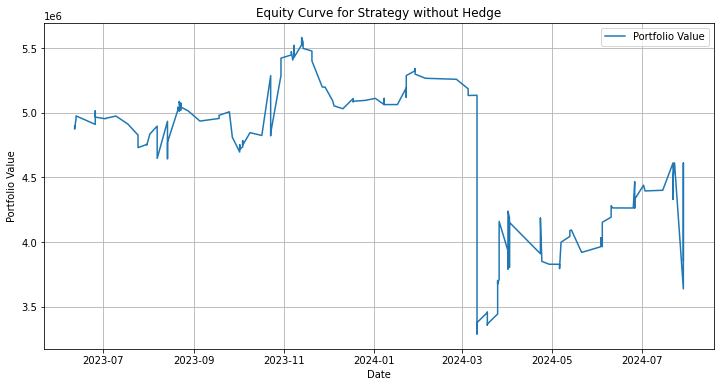

In [82]:
# Use the function to get portfolio values over time
portfolio_values_over_time = calculate_portfolio_value_over_time_from_positions(positions_with_liquidity)

# Convert to DataFrame for further processing
portfolio_df = pd.DataFrame(portfolio_values_over_time, columns=['Date', 'Portfolio Value'])
portfolio_df.sort_values('Date', inplace=True)
#portfolio_df.set_index('Date', inplace=True)

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio Value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Equity Curve for Strategy without Hedge')
plt.legend()
plt.grid(True)
plt.show()

Here is the two-way table aggregating the profits and losses, based on Action types and indices

In [85]:
positions_with_liquidity.sort_values('PnL', inplace=True)
positions_with_liquidity.head()

,Date,Ticker,Action,Index,PnL
169,2024-03-11,VKTX,Upweight,Russell 2000,-1.847355e+06
17,2024-07-29,AVTR,Add,SP400,-9.174377e+05
137,2024-04-01,RUN,SP400 to SP600,SP400,-3.074076e+05
46,2024-04-23,DUOL,Add,SP400,-2.745172e+05
57,2023-08-07,ERIE,Add,SP400,-2.063141e+05


In [70]:
# Assume positions_with_deduplication is the DataFrame containing the positions after running the strategy
positions_df = pd.DataFrame(positions_with_liquidity)

# Create a two-way table (pivot table)
two_way_table = pd.pivot_table(positions_df, values='PnL', index='Index', columns='Action', aggfunc='sum', fill_value=0)

two_way_table.loc['Total',:]= two_way_table.sum(axis=0)
two_way_table.loc[:,'Total'] = two_way_table.sum(axis=1)

# Display the two-way table
print("\nTwo-way table showing the Profit and Loss of entries for each action and index:")
two_way_table


Two-way table showing the Profit and Loss of entries for each action and index:


Action,Add,Delete,MSCI Std to SC,SP400 to SP600,SP500 to SP400,SP500 to SP600,SP600 to SP400,Upweight,Total
Index,,,,,,,,,
MSCI SC,-1423.952600,-52465.621173,53203.374321,0.000000,0.000000,0.000000,0.000000,2.444507e+05,2.437645e+05
MSCI Std,153906.379434,0.000000,53203.374321,0.000000,0.000000,0.000000,0.000000,3.042217e+05,5.113315e+05
Nasdaq 100,18587.148843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.858715e+04
Russell 1000,-429.706652,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.760048e+05,2.755750e+05
Russell 2000,-1394.223124,4862.848913,0.000000,0.000000,0.000000,0.000000,0.000000,-1.567307e+06,-1.563838e+06
S&P Completion,107172.128572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.071721e+05
SP400,-652815.196404,5736.743830,0.000000,-348918.888988,35451.862812,0.000000,286316.572042,7.578186e+04,-5.984470e+05
SP500,0.000000,0.000000,0.000000,0.000000,29385.808466,71090.057212,0.000000,-4.616966e+05,-3.612207e+05
SP600,250023.413654,-110767.016398,0.000000,-153388.583906,0.000000,71720.265760,197747.781259,-2.996431e+04,2.253715e+05


This strategy is down by 12% in the back-test period. Considering SPY went up during the same period, this isn't great.
In the two-way table aggregating the profits and losses, based on Action types and indices, we found that:

    1. We seem to be quite wrong about the behavior of MSCI;
    2. We are very wrong about the "Add" dynamic for Nasdaq 100 (interestingly, in the back-test period, Nasdaq 100 only has "Add" events)
    3. We are also very wrong about the "Upweight" dynamics. 

# 1 Modified Strategy with SPY hedges

First, we modify the strategy by adding a hedge from SPY on the short legs of the strategy, 
    
    i.e. to take a long position in SPY of equal value when we enter a short position, then close them at the same time.

    Since in the long term, SPY inceases in value, making a short leg in SPY as a hedge may be too risky.

Second, we change the "Upweight" part of the strategy to:

    a. To Long SP 500 after "Upweight" announcement for 5 days;

    b. To Short other indices' "Upweight" announcement for 5 days

Third, we also cap our trades to no more than 5% of our current portfolio value:

In [86]:
# Load SPY data
spy_data = pd.read_csv('D:\GitHub\Equity Project\AA SPDR_ETF_Data\SPY_data.csv')
spy_data['Date'] = pd.to_datetime(spy_data['Date'])

# Function to get SPY price on a given date
def get_spy_price(date):
    spy_price_data = spy_data[spy_data['Date'] == date]
    if not spy_price_data.empty:
        return spy_price_data['Close'].values[0]
    return None

# Apply strategy based on event rules with hedging
def apply_strategy_with_hedge(price_data):
    portfolio_value = 5000000
    positions = []

    grouped_data = price_data.groupby(['Ticker', 'Index', 'Action', 'Shares Traded'])

    for name, group in grouped_data:
        ticker, index, action, shares_traded = name

        if action == 'Add':
            if index in ['SP500', 'SP600']:
                # Long on day 1, sell on day 5
                d = group['Days from Announce'].min()
                long_day = group[group['Days from Announce'] == d]
                sell_day = group[group['Days from Announce'] == d+5]

                if not long_day.empty and not sell_day.empty:
                    buy_price = long_day.iloc[0]['Open']
                    sell_price = sell_day.iloc[0]['Close']
                    avg_volume = long_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares = avg_volume * 0.01
                    end = sell_day.iloc[0]['Date']

                    shares = min(0.05*portfolio_value // buy_price, max_shares)
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * buy_price, get_fed_rate(long_day.iloc[0]['Date']), 4, long=True)

                    pnl = (sell_price - buy_price) * shares - transaction_costs - overnight_costs
                    portfolio_value += pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

            else:
                # Short on day 1, cover on day 5
                d = group['Days from Announce'].min()
                short_day = group[group['Days from Announce'] == d]
                cover_day = group[group['Days from Announce'] == d+5]

                if not short_day.empty and not cover_day.empty:
                    short_price = short_day.iloc[0]['Open']
                    cover_price = cover_day.iloc[0]['Close']
                    avg_volume = short_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares_liquidity = avg_volume * 0.01
                    shares = min(0.05*portfolio_value // short_price, max_shares_liquidity)
                    end = cover_day.iloc[0]['Date']
    
                    # Hedge with SPY
                    entry_date = short_day.iloc[0]['Date']
                    exit_date = cover_day.iloc[0]['Date']
                    spy_entry_price = get_spy_price(entry_date)
                    spy_exit_price = get_spy_price(exit_date)
                    if spy_entry_price is None or spy_exit_price is None:
                        continue  # Skip if SPY prices are not available
    
                    spy_shares = shares * short_price / spy_entry_price
    
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * short_price, get_fed_rate(entry_date), 4, long=False)
                    spy_transaction_costs = calculate_transaction_costs(spy_shares)
                    spy_overnight_costs = calculate_overnight_costs(spy_shares * spy_entry_price, get_fed_rate(entry_date), 4, long=True)
    
                    pnl = (short_price - cover_price) * shares - transaction_costs - overnight_costs
                    spy_pnl = (spy_exit_price - spy_entry_price) * spy_shares - spy_transaction_costs - spy_overnight_costs
                    total_pnl = pnl + spy_pnl
                    portfolio_value += total_pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': total_pnl, 'Shares': shares})


        elif action == 'Delete':
            if index in ['SP400', 'SP500', 'SP600']:
                # Short on day 1, cover on day 5
                d = group['Days from Announce'].min()
                short_day = group[group['Days from Announce'] == d]
                cover_day = group[group['Days from Announce'] == d+5]

                if not short_day.empty and not cover_day.empty:
                    short_price = short_day.iloc[0]['Open']
                    cover_price = cover_day.iloc[0]['Close']
                    avg_volume = short_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares_liquidity = avg_volume * 0.01
                    shares = min(0.05*portfolio_value // short_price, max_shares_liquidity)
    
                    # Hedge with SPY
                    entry_date = short_day.iloc[0]['Date']
                    exit_date = cover_day.iloc[0]['Date']
                    spy_entry_price = get_spy_price(entry_date)
                    spy_exit_price = get_spy_price(exit_date)
                    if spy_entry_price is None or spy_exit_price is None:
                        continue  # Skip if SPY prices are not available
    
                    spy_shares = shares * short_price / spy_entry_price
    
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * short_price, get_fed_rate(entry_date), 4, long=False)
                    spy_transaction_costs = calculate_transaction_costs(spy_shares)
                    spy_overnight_costs = calculate_overnight_costs(spy_shares * spy_entry_price, get_fed_rate(entry_date), 4, long=True)
    
                    pnl = (short_price - cover_price) * shares - transaction_costs - overnight_costs
                    spy_pnl = (spy_exit_price - spy_entry_price) * spy_shares - spy_transaction_costs - spy_overnight_costs
                    total_pnl = pnl + spy_pnl
                    portfolio_value += total_pnl
                    positions.append({'Date': exit_date, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': total_pnl, 'Shares': shares})

            elif index in ['MSCI SC', 'NASDAQ 100', 'Russell 2000']:
                # Long on day 1, sell on day 5
                d = group['Days from Announce'].min()
                long_day = group[group['Days from Announce'] == d]
                sell_day = group[group['Days from Announce'] == d+5]
                

                if not long_day.empty and not sell_day.empty:
                    buy_price = long_day.iloc[0]['Open']
                    sell_price = sell_day.iloc[0]['Close']
                    avg_volume = long_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares = avg_volume * 0.01
                    end = sell_day.iloc[0]['Date']
                    
                    shares = min(0.05*portfolio_value // buy_price, max_shares)
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * buy_price, get_fed_rate(long_day.iloc[0]['Date']), 4, long=True)

                    pnl = (sell_price - buy_price) * shares - transaction_costs - overnight_costs
                    portfolio_value += pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

        elif action == 'Upweight':
            if index == 'SP500':
                # Long on day 1, sell on day 5
                d = group['Days from Announce'].min()
                long_day = group[group['Days from Announce'] == d]
                sell_day = group[group['Days from Announce'] == d+5]

                if not long_day.empty and not sell_day.empty:
                    buy_price = long_day.iloc[0]['Open']
                    sell_price = sell_day.iloc[0]['Close']
                    avg_volume = long_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares = avg_volume * 0.01
                    end = sell_day.iloc[0]['Date']

                    shares = min(0.05*portfolio_value // buy_price, max_shares)
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * buy_price, get_fed_rate(long_day.iloc[0]['Date']), 4, long=True)

                    pnl = (sell_price - buy_price) * shares - transaction_costs - overnight_costs
                    portfolio_value += pnl
                    positions.append({'Date': end, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': pnl})

            else:
                # Short on day 1, cover on day 5
                d = group['Days from Announce'].min()
                short_day = group[group['Days from Announce'] == d]
                cover_day = group[group['Days from Announce'] == d+5]

                if not short_day.empty and not cover_day.empty:
                    short_price = short_day.iloc[0]['Open']
                    cover_price = cover_day.iloc[0]['Close']
                    avg_volume = short_day.iloc[0]['20D_AVG_VOLUME']
                    max_shares_liquidity = avg_volume * 0.01
                    shares = min(0.05*portfolio_value // short_price, max_shares_liquidity)
    
                    # Hedge with SPY
                    entry_date = short_day.iloc[0]['Date']
                    exit_date = cover_day.iloc[0]['Date']
                    spy_entry_price = get_spy_price(entry_date)
                    spy_exit_price = get_spy_price(exit_date)
                    if spy_entry_price is None or spy_exit_price is None:
                        continue  # Skip if SPY prices are not available
    
                    spy_shares = shares * short_price / spy_entry_price
    
                    transaction_costs = calculate_transaction_costs(shares)
                    overnight_costs = calculate_overnight_costs(shares * short_price, get_fed_rate(entry_date), 4, long=False)
                    spy_transaction_costs = calculate_transaction_costs(spy_shares)
                    spy_overnight_costs = calculate_overnight_costs(spy_shares * spy_entry_price, get_fed_rate(entry_date), 4, long=True)
    
                    pnl = (short_price - cover_price) * shares - transaction_costs - overnight_costs
                    spy_pnl = (spy_exit_price - spy_entry_price) * spy_shares - spy_transaction_costs - spy_overnight_costs
                    total_pnl = pnl + spy_pnl
                    portfolio_value += total_pnl
                    positions.append({'Date': exit_date, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': total_pnl, 'Shares': shares})
                
        elif action in ['MSCI SC to Std', 'MSCI Std to SC', 'SP400 to SP600', 'SP400 to SP500', 'SP500 to SP400', 'SP500 to SP600', 'SP600 to SP400', 'SP600 to SP500']:
            # Short on day 1, cover on day 5
            d = group['Days from Announce'].min()
            short_day = group[group['Days from Announce'] == d]
            cover_day = group[group['Days from Announce'] == d+5]

            if not short_day.empty and not cover_day.empty:
                short_price = short_day.iloc[0]['Open']
                cover_price = cover_day.iloc[0]['Close']
                avg_volume = short_day.iloc[0]['20D_AVG_VOLUME']
                max_shares_liquidity = avg_volume * 0.01
                shares = min(0.05*portfolio_value // short_price, max_shares_liquidity)

                # Hedge with SPY
                entry_date = short_day.iloc[0]['Date']
                exit_date = cover_day.iloc[0]['Date']
                spy_entry_price = get_spy_price(entry_date)
                spy_exit_price = get_spy_price(exit_date)
                if spy_entry_price is None or spy_exit_price is None:
                    continue  # Skip if SPY prices are not available

                spy_shares = shares * short_price / spy_entry_price

                transaction_costs = calculate_transaction_costs(shares)
                overnight_costs = calculate_overnight_costs(shares * short_price, get_fed_rate(entry_date), 4, long=False)
                spy_transaction_costs = calculate_transaction_costs(spy_shares)
                spy_overnight_costs = calculate_overnight_costs(spy_shares * spy_entry_price, get_fed_rate(entry_date), 4, long=True)

                pnl = (short_price - cover_price) * shares - transaction_costs - overnight_costs
                spy_pnl = (spy_exit_price - spy_entry_price) * spy_shares - spy_transaction_costs - spy_overnight_costs
                total_pnl = pnl + spy_pnl
                portfolio_value += total_pnl
                positions.append({'Date': exit_date, 'Ticker': ticker, 'Action': action, 'Index': index, 'PnL': total_pnl, 'Shares': shares})

    return portfolio_value-5000000, pd.DataFrame(positions)

# Run the strategy with liquidity constraint
final_value_with_hedge, positions_with_hedge = apply_strategy_with_hedge(price_data)

print('Total rate of return during Backtesting Period: ' + str(final_value_with_hedge/50000) + "%")

#positions_with_hedge.head()



Total rate of return during Backtesting Period: 0.042094663762636486%


In [87]:
# # Convert 'Date' columns to datetime if not already done
# positions_with_liquidity['Date'] = pd.to_datetime(positions_with_liquidity['Date'])
# positions_with_hedge['Date'] = pd.to_datetime(positions_with_hedge['Date'])

# # Merge the dataframes on ['Date', 'Ticker', 'Index', 'Action'] with indicator
# merged = positions_with_liquidity.merge(
#     positions_with_hedge,
#     on=['Date', 'Ticker', 'Index', 'Action'],
#     how='left',
#     indicator=True
# )

# # Filter entries that are only in positions_with_liquidity
# only_in_liquidity = merged[merged['_merge'] == 'left_only']

# # Drop the merge indicator column if not needed
# only_in_liquidity.drop(columns=['_merge'], inplace=True)

# # print(only_in_liquidity)

# # print(positions_with_liquidity)


Here is the plot for portfolio value over time:

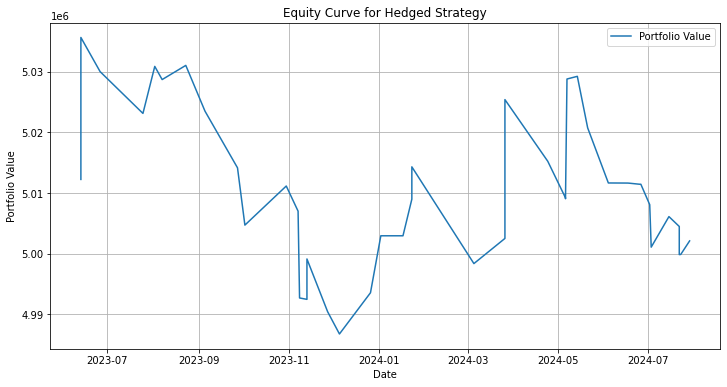

In [88]:
# Use the function to get portfolio values over time
portfolio_values_over_time = calculate_portfolio_value_over_time_from_positions(positions_with_hedge)

# Convert to DataFrame for further processing
portfolio_df = pd.DataFrame(portfolio_values_over_time, columns=['Date', 'Portfolio Value'])
portfolio_df.sort_values('Date', inplace=True)
#portfolio_df.set_index('Date', inplace=True)

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio Value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Equity Curve for Hedged Strategy')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# Create a two-way table (pivot table)
two_way_table = pd.pivot_table(positions_with_hedge, values='PnL', index='Index', columns='Action', aggfunc='sum', fill_value=0)

two_way_table.loc['Total',:]= two_way_table.sum(axis=0)
two_way_table.loc[:,'Total'] = two_way_table.sum(axis=1)

# Display the two-way table
print("\nTwo-way table showing the Profit and Loss of entries for each action and index:")
two_way_table


Two-way table showing the Profit and Loss of entries for each action and index:


Action,Add,Delete,Upweight,Total
Index,,,,
MSCI SC,0.000000,-2454.161330,0.000000,-2454.161330
Russell 2000,0.000000,4869.935368,0.000000,4869.935368
SP500,0.000000,0.000000,-39576.558371,-39576.558371
SP600,39265.517521,0.000000,0.000000,39265.517521
Total,39265.517521,2415.774038,-39576.558371,2104.733188


Why doesn't the 2nd version do anything on reclassification events still eludes me ...

In [89]:
import pandas as pd

# Function to ensure 'Date' columns are datetime and timezone-naive
def ensure_datetime(df, column):
    df[column] = pd.to_datetime(df[column], errors='coerce')
    if df[column].dt.tz is not None:
        df[column] = df[column].dt.tz_localize(None)
    return df

# Convert positions_with_liquidity to DataFrame
positions_with_liquidity_df = positions_with_hedge
positions_with_liquidity_df['Date'] = pd.to_datetime(positions_with_liquidity_df['Date'], utc=True).dt.tz_localize(None).dt.strftime('%Y-%m-%d')

# Load SPY data
spy_data = pd.read_csv('D:\GitHub\Equity Project\AA SPDR_ETF_Data\SPY_data.csv')
spy_data['Date'] = pd.to_datetime(spy_data['Date'], utc=True).dt.tz_localize(None).dt.strftime('%Y-%m-%d')
spy_data.set_index('Date', inplace=True)

# Load Fed Funds data
fed_funds = pd.read_csv('D:\GitHub\Equity Project\AB Fed Funds Rate\FEDFUNDS.csv')
fed_funds = ensure_datetime(fed_funds, 'Date')
fed_funds.set_index('Date', inplace=True)

# Use the function to get portfolio values over time
portfolio_values_over_time = calculate_portfolio_value_over_time_from_positions(positions_with_liquidity_df)

# Convert to DataFrame for further processing
portfolio_df = pd.DataFrame(portfolio_values_over_time, columns=['Date', 'Portfolio Value'])
portfolio_df.sort_values('Date', inplace=True)
portfolio_df.set_index('Date', inplace=True)

# Calculate daily returns for the strategy
portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change()

# # Check data types and values
# print("Data types in portfolio_df:", portfolio_df.dtypes)
# print("Data types in spy_data:", spy_data.dtypes)
# print("Data types in fed_funds:", fed_funds.dtypes)

# # Check first few rows to verify date consistency
# print("First few rows in portfolio_df:\n", portfolio_df.head())
# print("First few rows in spy_data:\n", spy_data.head())
# print("First few rows in fed_funds:\n", fed_funds.head())

# Ensure 'Return' in spy_data is numeric
spy_data['Return'] = pd.to_numeric(spy_data['Return'], errors='coerce')

# Align dates with SPY data and use the existing 'Return' column
merged_df = portfolio_df.merge(spy_data[['Return']], left_index=True, right_index=True, suffixes=('_Strategy', '_SPY'))

# Calculate the risk-free rate (daily)
fed_funds['Daily Rate'] = (fed_funds['FEDFUNDS'] / 100) / 365

# Forward fill the daily rate to align with daily returns
daily_fed_funds = fed_funds.resample('D').ffill()

merged_df.index = pd.to_datetime(merged_df.index, errors='coerce')
merged_df.index = merged_df.index.tz_localize(None)
daily_fed_funds.index = pd.to_datetime(daily_fed_funds.index, errors='coerce')
daily_fed_funds.index = daily_fed_funds.index.tz_localize(None)

# Merge with the risk-free rate to align dates
merged_df = merged_df.merge(daily_fed_funds['Daily Rate'], left_index=True, right_index=True)

# Calculate excess returns for the strategy
merged_df['Excess Return'] = merged_df['Daily Return'] - merged_df['Daily Rate']

# Calculate the Sharpe ratio
average_excess_return = merged_df['Excess Return'].mean()
std_excess_return = merged_df['Excess Return'].std()
sharpe_ratio = average_excess_return / std_excess_return

print(f'Sharpe Ratio: {sharpe_ratio}')

merged_df['Excess SPY Return'] = merged_df['Return']-merged_df['Daily Rate']
sharpe_SPY = merged_df['Excess Return'].mean()/merged_df['Excess Return'].std()

#print(f'Sharpe Ratio for Holding SPY: {sharpe_SPY}')


Sharpe Ratio: -0.0789876576055362


Our modified strategy has a Sharpe of -0.07, indicating high variance.